# OCSMesh Tutorial

Import module required throughout this tutorial

In [1]:
from pathlib import Path 
import requests
import tempfile
import zipfile

import geopandas as gpd
from cartopy.feature import NaturalEarthFeature
import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry

import ocsmesh

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Define constants, paths, useful datasets, etc.

<AxesSubplot: >

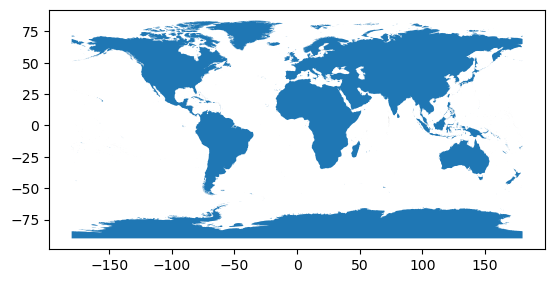

In [2]:
data = Path('./data')

#gdf_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', scale='10m', name='land').geometries(), crs=4326)

gdf_countries.plot()

If you're using a machine without internet access, e.g. compute nodes, then you need to download the shapefiles by `cartopy_feature_download.py physical` from another machine and then copy it from `~/.local/share/cartopy/shapefiles/natural_earth/physical/ne_10m_land.*`


OCSMesh generates the unstructured mesh within the **Geometry** and based on the sizes defined by the **Size function**. 
The role of the modeler is to create these two objects based on the **mesh requirements** using tools available within or even outside `ocsmesh`.

## Geometry
In the context of mesh generation using `ocsmesh`, *geometry* is the defintion of the region or domain to be meshed.
There are **3** basic ways of defining the geometry. There's also a **4th** method which is in essence *combination* of multiple of the basic types!
The jobs of OCSMesh's geometry object is to process the inputs and user specifications and eventually provide **polygons** to be meshed to the meshing engine (Jigsaw). This output polygon from the geometry is of a custom type defined by Jigsaw.

All geometry object types are created by passing the correct type of argument to the `ocsmesh.Geom` factory class. It is also possible for the user to directly create specific type of geometry class by creating an `ocsmesh.geom.mesh.MeshGeom` for example.

### Shape based
The most basic way for a user to define the meshing domain (i.e. geometry) is to specify a polygon or list of polygons. This way, the only thing geometry object needs to do is to pass the same input polygon to the mesh engine! The classes that define these objects are `ocsmesh.geom.shapely.PolygonGeom` and `ocsmesh.geom.shapely.MultiPolygonGeom`.

It's important to note that the **format** of input polygon and output polygon of the geometry object are **different**. The input polygon needs to be of type `shapely.geometry.Polygon` or `shapely.geometry.MultiPolygon`. *Shapely* (along with *PyGEOS*) is one the the most commonly used `GEOS` library wrappers in Python; many of the Python packages (e.g. `geopandas`) support Shapely objects, which makes is easier for the user to operate on the shapes until it meets their desired criteria, and then pass it to OCSMesh via `ShapelyGeom`.

Shape-based geometry gives the user full control on how the domain looks like. The user can manipulate the input shape, add or subtract segmets from it and then finally pass it to the `Geom` factory class to retrieve an OCSMesh geometry object:

In [3]:
gdf_oceans = gpd.GeoDataFrame(geometry=[geometry.box(*gdf_countries.total_bounds).difference(gdf_countries.unary_union)], crs=gdf_countries.crs)
roi_box = geometry.box(-74.5, 39.5, -71.5, 41.5)
gdf_roi_domain = gdf_oceans.intersection(roi_box)
geom_obj_1 = ocsmesh.Geom(gdf_roi_domain.unary_union, crs=gdf_roi_domain.crs)

Which we can plot to get the following. Note that `get_multipolygon` method returns a Shapely object, while `msh_t` returns Jigsaw polygon (used for passing info to mesh engine):

<AxesSubplot: >

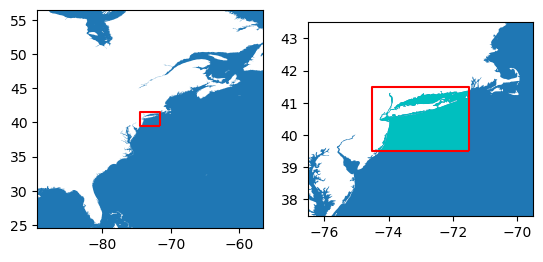

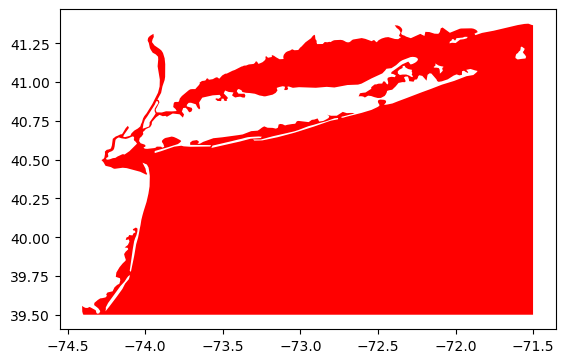

In [4]:
fig_1, axs_1 = plt.subplots(1, 2)

ax = axs_1[0]
gdf_oceans.plot(ax=ax)
gpd.GeoSeries(roi_box).boundary.plot(ax=ax, color='r')
ax.set_xlim(roi_box.bounds[0] - 15, roi_box.bounds[2] + 15)
ax.set_ylim(roi_box.bounds[1] - 15, roi_box.bounds[3] + 15)
ax.set_aspect(1)

ax = axs_1[1]
gdf_oceans.plot(ax=ax)
gpd.GeoSeries(roi_box).boundary.plot(ax=ax, color='r')
gdf_roi_domain.plot(ax=ax, color='c')
ax.set_xlim(roi_box.bounds[0] - 2, roi_box.bounds[2] + 2)
ax.set_ylim(roi_box.bounds[1] - 2, roi_box.bounds[3] + 2)
ax.set_aspect(1)


geom_poly_1 = geom_obj_1.get_multipolygon()
gpd.GeoSeries(geom_poly_1).plot(color='r')

### Mesh based

The next type of geometry definition is by mesh. That means the domain of meshing will be the same as the existing mesh that is passed as input. The class `ocsmesh.geom.mesh.MeshGeom` defines this type of object:

Let's download an example *Shinnecock Inlet* mesh from ADCIRC examples first:

In [5]:
#_tmp = requests.get('https://www.dropbox.com/s/t2e26p11ep0ydx1/shinnecock_inlet_test_case.zip?dl=1')
#with open('shinnecock.zip', 'wb') as fo:
#    fo.write(_tmp.content)

Note that if you're running this notebook on a machine without internet access, you need to download the data separately by `wget https://www.dropbox.com/s/t2e26p11ep0ydx1/shinnecock_inlet_test_case.zip?dl=1 -O data/shinnecock.zip` and before running the notebook and comment the download lines.

In [6]:
#with open(data / 'shinnecock.zip', 'r') as fo:    
#    archive = zipfile.ZipFile(fo, 'r')
#    archive.extract('fort.14')

Now we need to create a *mesh object* and then pass that mesh object to the `Geom` factory to create a geometry object based on mesh:

In [7]:
mesh_obj_2 = ocsmesh.Mesh.open(data/'fort.14', crs=4326)
geom_obj_2 = ocsmesh.Geom(mesh_obj_2)

Now we can draw the mesh and the geometry:

/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/mesh/mesh.py:739: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in polys:


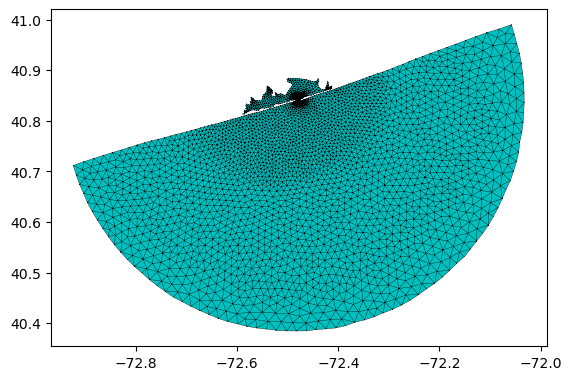

In [8]:
mesh_crd_2 = mesh_obj_2.msh_t.vert2['coord']
mesh_cnn_2 = mesh_obj_2.msh_t.tria3['index']

geom_poly_2 = geom_obj_2.get_multipolygon()

ax = gpd.GeoSeries(geom_poly_2).plot(color='c')
ax.triplot(mesh_crd_2[:, 0], mesh_crd_2[:, 1], mesh_cnn_2, color='k', linewidth=0.25)

### Raster based

Raster based geometry object is the most feature rich type of geometry. The user doesn't have as much control over the exact shape, unlike when using mesh based geom, but rather controls the domain based on specific criteria for which data from raster is used. To demo it, let's download a couple of DEM files first:

In [9]:
ny_cudem_url = [
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n41x00_w074x25_2015v1.tif",
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n41x00_w074x00_2015v1.tif",
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n40x75_w074x25_2015v1.tif",
    "https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/northeast_sandy/ncei19_n40x75_w074x00_2015v1.tif"
]
ny_cudem = []
for i in ny_cudem_url:
    # Uncomment to download the data
#    _tmp = requests.get(i)
#    with open(filename, 'wb') as fo:
#        fo.write(_tmp.content)
        
    filename = data / i.split('/')[-1]
    ny_cudem.append(filename)

Like before not that data might need to be downloaded before hand using `wget`, e.g. if running on compute nodes

Let's see how do they look:

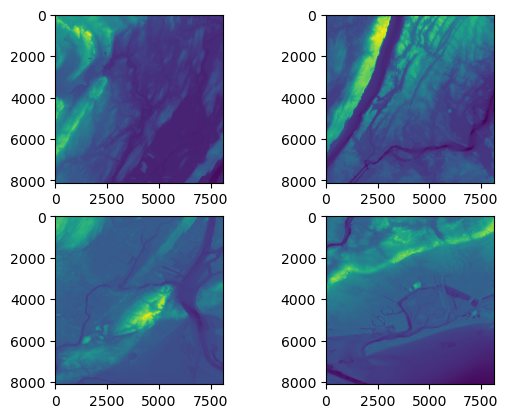

In [10]:
rasters = [ocsmesh.Raster(i) for i in ny_cudem]

fig_2, axs_2 = plt.subplots(2, 2)
for ax, rast in zip(axs_2.ravel(), rasters):
    ax.imshow(rast.get_values())
fig_2.show()

Now let's use these rasters to create geometry. To create `RasterGeom`, the user needs to pass a `ocsmesh.Raster` object to the `Geom` factory class:

<AxesSubplot: >

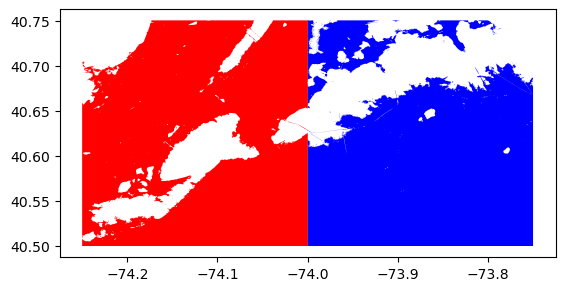

In [11]:
geom_obj_3 = ocsmesh.Geom(rasters[3], zmax=10)
geom_poly_3 = geom_obj_3.get_multipolygon()

geom_obj_4 = ocsmesh.Geom(rasters[2], zmax=15)
geom_poly_4 = geom_obj_4.get_multipolygon()

ax_3 = gpd.GeoSeries(geom_poly_3).plot(color='b')
gpd.GeoSeries(geom_poly_4).plot(color='r', ax=ax_3)

### Collection geometry
But what if we want to create a single geometry from a combination of multiple DEMs, or DEM combined with shape geometry? To achieve this, one can create a geometry object for each fo the DEMs or shape inputs, then get the resulting `Polygon` by `get_multipolygon()`, then union all the shapes and finally create a new goemetry object from the combined shape.

While this is certainly possible, and gives the user more control over all the details, an easier way in generic cases would be to just use `GeomCollector` objects. These objects are created as a result of passing a list of DEMs and potentially other OCSMesh geometry object types to the `Geom` factory class:

/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rasters_gdf = rasters_gdf.append(
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/ops/combine_geom.py:226: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rasters_gdf = rasters_gdf.append(
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/sandbox/geomesh/ocsmesh/geom/collector.py:317: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(gpd.read_feather(f))
/scratch2/COASTAL/coastal/noscrub/Soroosh.Mani/apps/miniconda3/envs/simulation/lib/python3.9/site-packages/pygeos/set_operations.py:388: RuntimeWarning: invalid value encountered in unary_union
  result 

<AxesSubplot: >

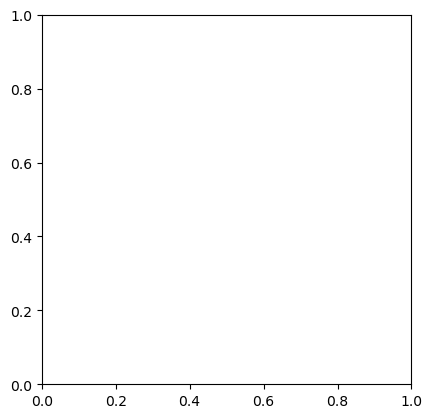

In [12]:
geom_obj_5 = ocsmesh.Geom(rasters[2:], zmax=10)
geom_poly_5 = geom_obj_5.get_multipolygon()

gpd.GeoSeries(geom_poly_5).plot(color='c')

It automatically generates the multipolygon from each input (raster, mesh, and shapes) and then compbines all of the polygons to obtain the total domain.

## Size function
Size function specifies element size at each location within the domain.

Doesn't need to be defined only in domain. Also doesn't need to cover full domain!

### Mesh based
### Raster based
## Mesh
### Parsers
## Tools
### Raster manipulation
### Mesh object manipulation